In [1]:
%matplotlib inline

import sys
import os

root_path = os.path.dirname(os.getcwd())
if root_path not in sys.path:
    sys.path.append(root_path)

import torch
import gc

from torch.utils.data import DataLoader
from lirGAN.model import LirDataset, LirGenerator, LirDiscriminator, LirGeometricLoss, LirGanTrainer
from lirGAN.data import utils
from lirGAN.config import ModelConfig

torch.cuda.empty_cache()
gc.collect()

print("torch.cuda.is_available():", torch.cuda.is_available())


torch.cuda.is_available(): True


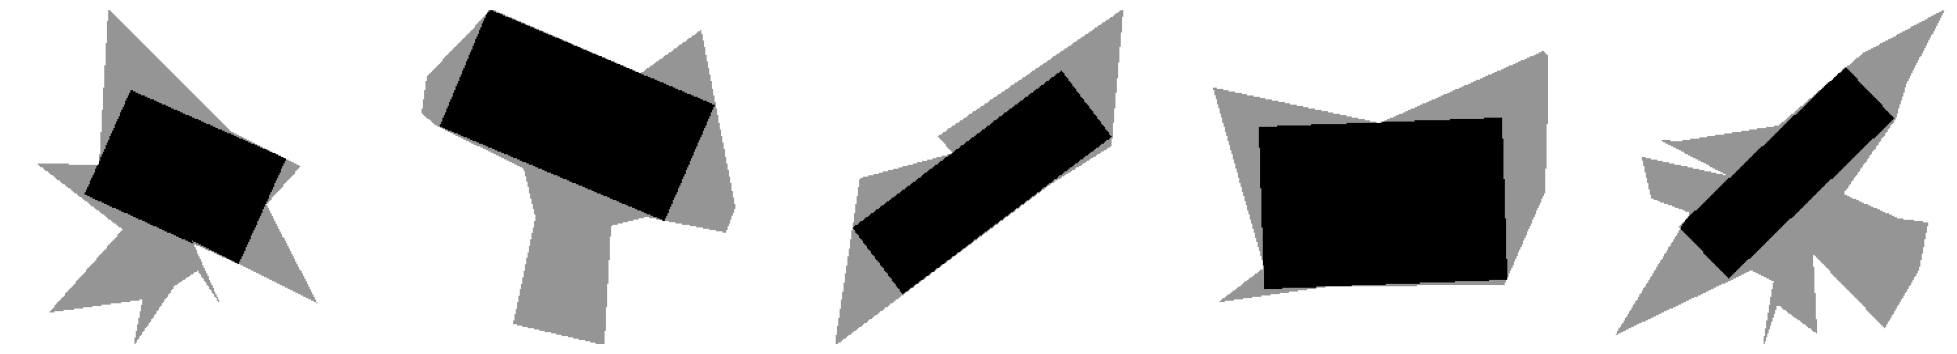

In [4]:
"""visualizing boundary polygons and target rectangles
"""

slicer = 5
lir_dataset_to_visualize = LirDataset(slicer=slicer)

binary_grids = []
for i in range(slicer):
    input_polygon, target_ilr = lir_dataset_to_visualize[i]
    merged_grid = (input_polygon.squeeze() + target_ilr.squeeze()).detach().cpu().numpy()
    
    binary_grids.append(merged_grid)

utils.plot_binary_grids(binary_grids)

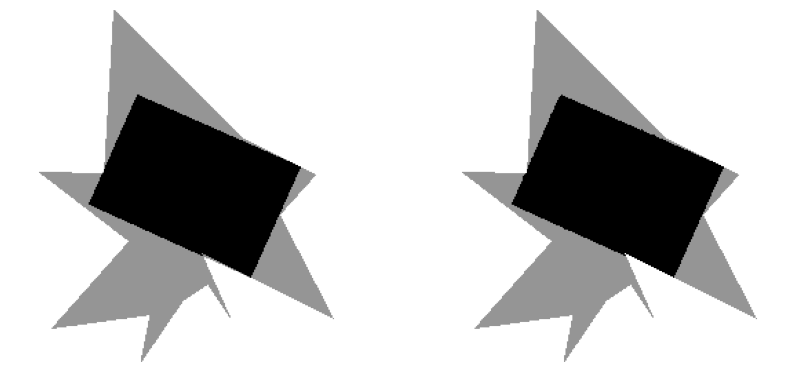

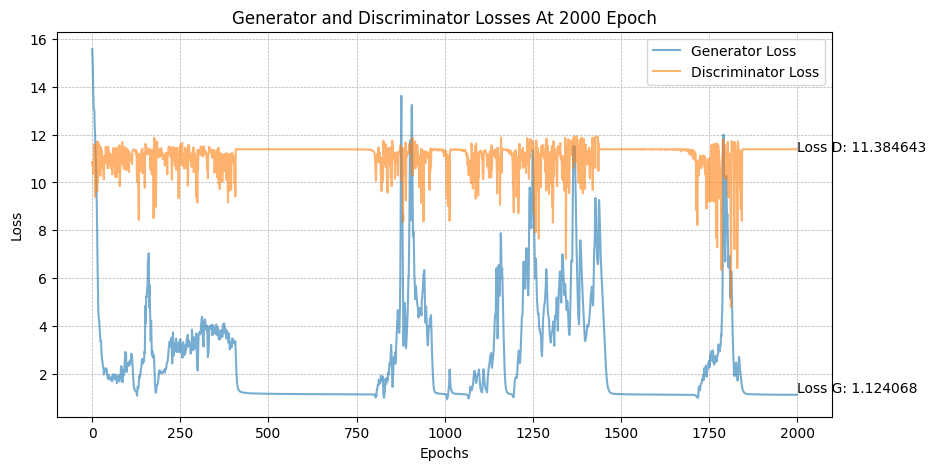

In [2]:
"""Test to train models with Geometric loss function & Tanh"""
"""Test base models using only one data"""

lir_dataset = LirDataset(slicer=1)
lir_dataloader = DataLoader(
    dataset=lir_dataset,
    batch_size=ModelConfig.BATCH_SIZE,
    shuffle=True,
)

lir_generator = LirGenerator(use_tanh=True)
lir_discriminator = LirDiscriminator()
lir_geometric_loss_function = LirGeometricLoss(
    bce_weight=1.0, diou_weight=2.0, feasibility_weight=5.0, connectivity_weight=0.3
)

lir_gan_trainer = LirGanTrainer(
    epochs=2000,
    lir_generator=lir_generator,
    lir_discriminator=lir_discriminator,
    lir_dataloader=lir_dataloader,
    lir_geometric_loss_function=lir_geometric_loss_function,
    initial_weights_key=ModelConfig.XAVIER,
    use_gradient_penalty=True,
    is_record=True,
    record_name="with-geometric-loss-2000-epochs",
)

lir_gan_trainer.set_seed()
lir_gan_trainer.train()

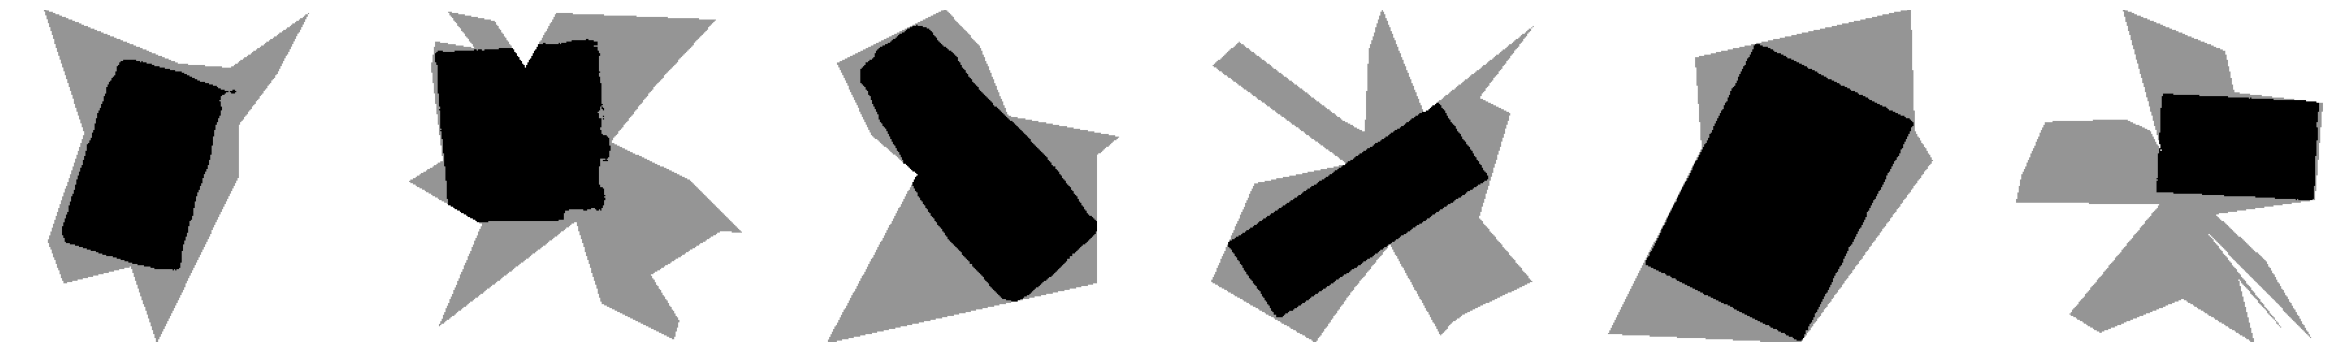

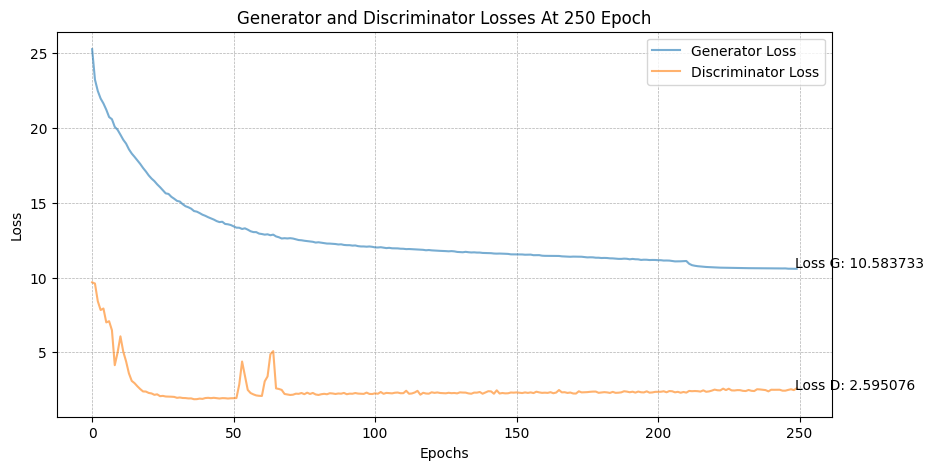

In [3]:
"""Train models with Geometric loss and Tanh using all data"""
"""Test base models using all data"""

lir_dataset = LirDataset()
lir_dataloader = DataLoader(
    dataset=lir_dataset,
    batch_size=32,
    shuffle=True,
    drop_last=True,
)

lir_generator = LirGenerator(use_tanh=True)
lir_discriminator = LirDiscriminator()

# Set all weights are 0.0 excerpt bce weight
lir_geometric_loss_function = LirGeometricLoss(
    bce_weight=1.0, diou_weight=0.5, feasibility_weight=0.01, connectivity_weight=0.01
)

lir_gan_trainer = LirGanTrainer(
    epochs=3,
    lir_generator=lir_generator,
    lir_discriminator=lir_discriminator,
    lir_dataloader=lir_dataloader,
    lir_geometric_loss_function=lir_geometric_loss_function,
    initial_weights_key=ModelConfig.XAVIER,
    log_interval=1,
    use_gradient_penalty=True,
    use_lr_scheduler=True,
    is_record=True,
    record_name="with-geometric-loss-all-data",
)

lir_gan_trainer.set_seed()
lir_gan_trainer.train()